<h3> Summary of this notebook: </h3>

- NMT model using Transformer using sub-classed layers
- Training works
- Predicting works
- Plotting of attention weights works
- Saving works

<h3> Next steps: </h3>

- Put all helper functions, subclassed layers, and Transformer object into python file
- Only call in the notebook

In [1]:
import pandas as pd
import numpy as np
import string
from string import digits
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import tensorflow as tf
from tensorflow.keras.layers import Bidirectional, Concatenate, LSTM, Embedding, Dense, MultiHeadAttention, LayerNormalization, Dropout
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow.keras.initializers import Constant
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split
import re
import os
import io
import time


In [2]:
# from google.colab import drive
# drive.mount('/content/gdrive')

# df_en_de = pd.read_table('/content/gdrive/MyDrive/deu-eng/deu.txt', names=['eng', 'deu', 'attr'])

In [2]:
df_en_de = pd.read_table('deu-eng/deu.txt', names=['eng', 'deu', 'attr'])
df_en_de = df_en_de.drop('attr',axis = 1).rename(columns = {'eng':'english', 'deu':'german'})

In [3]:
def preprocess_sentence(sentence):
    sentence = sentence.lower()
    sentence = re.sub("'", '', sentence)
    sentence = sentence.replace('ü', 'ue').replace('ä', 'ae').replace('ö', 'oe').replace('ß', 'ss')
    exclude = set(string.punctuation)
    sentence = ''.join(ch for ch in sentence if ch not in exclude)
    sentence = 'start_ ' + sentence + ' _end'
    sentence = sentence.encode("ascii", "ignore")
    sentence = sentence.decode()
    return sentence

In [4]:
pairs = df_en_de
pairs = pairs.sample(frac = 0.05)
pairs['english'] = pairs['english'].apply(preprocess_sentence)
pairs['german'] = pairs['german'].apply(preprocess_sentence)

In [211]:
pairs.head()['english']

107228               start_ we walked about five miles _end
193691    start_ he is often late for school on mondays ...
23396                           start_ hi tom whats up _end
198164    start_ according to tom mary has sold her car ...
186486     start_ tom will probably be absent tomorrow _end
Name: english, dtype: object

In [5]:
source = pairs['english']
target = pairs ['german']

In [6]:
# create tokenizer & tensor for source and target
source_sentence_tokenizer= Tokenizer(filters='')
source_sentence_tokenizer.fit_on_texts(source)
source_tensor = source_sentence_tokenizer.texts_to_sequences(source)
source_tensor= tf.keras.preprocessing.sequence.pad_sequences(source_tensor, padding='post' )

target_sentence_tokenizer= Tokenizer(filters='')
target_sentence_tokenizer.fit_on_texts(target)
target_tensor = target_sentence_tokenizer.texts_to_sequences(target)
target_tensor= tf.keras.preprocessing.sequence.pad_sequences(target_tensor, padding='post' )

In [214]:
type(source_tensor)

numpy.ndarray

In [213]:
source_tensor[0], source_tensor[4]

(array([  1,  25, 594,  49, 659, 902,   2,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0], dtype=int32),
 array([   1,    3,   63,  333,   30, 1668,  170,    2,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0], dtype=int32))

In [212]:
source_sentence_tokenizer.texts_to_sequences(['start_ we walked about five miles _end', 'start_ tom will probably be absent tomorrow _end'])

[[1, 25, 594, 49, 659, 902, 2], [1, 3, 63, 333, 30, 1668, 170, 2]]

In [7]:
# Create word to index and index to word mappings for source and target

source_word_index = source_sentence_tokenizer.word_index
target_word_index = target_sentence_tokenizer.word_index

source_index_word = source_sentence_tokenizer.index_word
target_index_word = target_sentence_tokenizer.index_word

In [8]:
vocab_len_source = len(source_word_index.keys())
vocab_len_target = len(target_word_index.keys())
vocab_len_source, vocab_len_target

(5407, 8338)

In [9]:
num_tokens_source = vocab_len_source + 1
num_tokens_target = vocab_len_target + 1

In [10]:
source_train_tensor, source_test_tensor, target_train_tensor, target_test_tensor = train_test_split(
                                                                source_tensor, target_tensor,test_size=0.2
                                                                )

In [11]:
max_target_length= max(len(t) for t in  target_tensor)
max_source_length= max(len(t) for t in source_tensor)

In [12]:
max_target_length, max_source_length

(27, 29)

In [13]:
BATCH_SIZE = 32
#Create data in memeory 
dataset = tf.data.Dataset.from_tensor_slices((source_train_tensor, target_train_tensor)).shuffle(BATCH_SIZE)
# shuffles the data in the batch
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

2022-08-15 12:03:23.373213: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [220]:
source_batch, target_batch =next(iter(dataset))
# print(source_batch.shape, target_batch.shape)
# print(source_batch[1])
# print(type(source_batch))
# print (type(source_batch[0]))
tf.convert_to_tensor(source_batch[0])

<tf.Tensor: shape=(29,), dtype=int32, numpy=
array([  1,  14,  39,  38, 140, 108, 177,   2,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0], dtype=int32)>

In [15]:
def get_angles(pos, k, d):
    """
    Get the angles for the positional encoding
    
    Arguments:
        pos -- Column vector containing the positions [[0], [1], ...,[N-1]]
        k --   Row vector containing the dimension span [[0, 1, 2, ..., d-1]]
        d(integer) -- Encoding size
    
    Returns:
        angles -- (pos, d) numpy array 
    """

    # Get i from dimension span k
    i = k // 2
    # Calculate the angles using pos, i and d
    angles = pos / (10000 ** (2*i/d))
    
    return angles

In [16]:
def positional_encoding(positions, d):
    """
    Precomputes a matrix with all the positional encodings 
    
    Arguments:
        positions (int) -- Maximum number of positions to be encoded 
        d (int) -- Encoding size 
    
    Returns:
        pos_encoding -- (1, position, d_model) A matrix with the positional encodings
    """

    # initialize a matrix angle_rads of all the angles 
    angle_rads = get_angles(np.array(list(range(positions))).reshape((positions,1)),
                            np.array(list(range(d))).reshape((1,d)),
                            d
                            )
  
    # apply sin to even indices in the array; 2i
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
  
    # apply cos to odd indices in the array; 2i+1
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    
    pos_encoding = angle_rads[np.newaxis, ...]
    print(pos_encoding.shape)
    return tf.cast(pos_encoding, dtype=tf.float32)

(1, 50, 512)
(1, 50, 512)


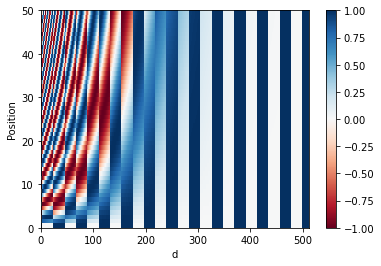

In [17]:
pos_encoding = positional_encoding(50, 512)

print (pos_encoding.shape)

plt.pcolormesh(pos_encoding[0], cmap='RdBu')
plt.xlabel('d')
plt.xlim((0, 512))
plt.ylabel('Position')
plt.colorbar()
plt.show()

In [52]:
def create_padding_mask(seq):
    """
    Creates a matrix mask for the padding cells
    
    Arguments:
        seq -- (batch_size, seq_len) 
    
    Returns:
        mask -- (batch_size, 1, seq_len) binary tensor
    """    
    seq = 1 - tf.cast(tf.math.equal(seq, 0), tf.float32)
  
    # add extra dimensions to add the padding
    # to the attention logits.
    return seq[:, tf.newaxis, :] 

In [53]:
x = tf.constant([[7., 6., 0., 0., 1.], [1., 2., 3., 0., 0.], [0., 0., 0., 4., 5.]])
print(create_padding_mask(x))

tf.Tensor(
[[[1. 1. 0. 0. 1.]]

 [[1. 1. 1. 0. 0.]]

 [[0. 0. 0. 1. 1.]]], shape=(3, 1, 5), dtype=float32)


In [20]:
print(tf.keras.activations.softmax(x))
print(tf.keras.activations.softmax(x + (1 - create_padding_mask(x)) * -1.0e9))

tf.Tensor(
[[7.2876638e-01 2.6809818e-01 6.6454895e-04 6.6454895e-04 1.8064313e-03]
 [8.4437370e-02 2.2952457e-01 6.2391245e-01 3.1062772e-02 3.1062772e-02]
 [4.8541026e-03 4.8541026e-03 4.8541026e-03 2.6502505e-01 7.2041273e-01]], shape=(3, 5), dtype=float32)
tf.Tensor(
[[[7.2973627e-01 2.6845497e-01 0.0000000e+00 0.0000000e+00 1.8088354e-03]
  [2.4472848e-01 6.6524094e-01 0.0000000e+00 0.0000000e+00 9.0030573e-02]
  [6.6483542e-03 6.6483542e-03 0.0000000e+00 0.0000000e+00 9.8670328e-01]]

 [[7.3057157e-01 2.6876226e-01 6.6619506e-04 0.0000000e+00 0.0000000e+00]
  [9.0030566e-02 2.4472845e-01 6.6524088e-01 0.0000000e+00 0.0000000e+00]
  [3.3333334e-01 3.3333334e-01 3.3333334e-01 0.0000000e+00 0.0000000e+00]]

 [[0.0000000e+00 0.0000000e+00 0.0000000e+00 2.6894143e-01 7.3105860e-01]
  [0.0000000e+00 0.0000000e+00 0.0000000e+00 5.0000000e-01 5.0000000e-01]
  [0.0000000e+00 0.0000000e+00 0.0000000e+00 2.6894143e-01 7.3105860e-01]]], shape=(3, 3, 5), dtype=float32)


In [21]:
def create_look_ahead_mask(sequence_length):
    """
    Returns a lower triangular matrix filled with ones
    
    Arguments:
        sequence_length -- matrix size
    
    Returns:
        mask -- (size, size) tensor
    """
    mask = tf.linalg.band_part(tf.ones((1, sequence_length, sequence_length)), -1, 0)
    
    #K: band_part: tf.linalg.bandPart (a, numLower, numUpper)
    #a: it is tf.tensor to be passed.
    #numLower: Number of subdiagonals to keep. If negative, keep entire lower triangle
    #numUpper: Number of subdiagonals to keep. If negative, keep entire upper triangle
    
    return mask 

In [22]:
x = tf.random.uniform((1, 3))
temp = create_look_ahead_mask(x.shape[1])
temp

<tf.Tensor: shape=(1, 3, 3), dtype=float32, numpy=
array([[[1., 0., 0.],
        [1., 1., 0.],
        [1., 1., 1.]]], dtype=float32)>

<h3> Encoder </h3>

In [23]:
def FullyConnected(embedding_dim, fully_connected_dim):
    return tf.keras.Sequential([
        tf.keras.layers.Dense(fully_connected_dim, activation='relu'),  # (batch_size, seq_len, dff)
        tf.keras.layers.Dense(embedding_dim)  # (batch_size, seq_len, d_model)
    ])

In [24]:
class EncoderLayer(tf.keras.layers.Layer):
    """
    The encoder layer is composed of a multi-head self-attention mechanism,
    followed by a simple, positionwise fully connected feed-forward network. 
    This archirecture includes a residual connection around each of the two 
    sub-layers, followed by layer normalization.
    """
    def __init__(self, embedding_dim, num_heads, fully_connected_dim,
                 dropout_rate=0.1, layernorm_eps=1e-6):
        super(EncoderLayer, self).__init__()
        #K: Note: key_dim refers to the final dimensiosn AFTER concatenating the multiple heads.
        # And we want this to be the same as embedding_dim, since we are stacking multiple MHA layers
        self.mha = MultiHeadAttention(num_heads=num_heads,
                                      key_dim=embedding_dim,
                                      dropout=dropout_rate)

        self.ffn = FullyConnected(embedding_dim=embedding_dim,
                                  fully_connected_dim=fully_connected_dim)

        self.layernorm1 = LayerNormalization(epsilon=layernorm_eps)
        self.layernorm2 = LayerNormalization(epsilon=layernorm_eps)

        self.dropout_ffn = Dropout(dropout_rate)
    
    def call(self, x, training, mask):


        """
        Forward pass for the Encoder Layer
        
        Arguments:
            x -- Tensor of shape (batch_size, input_seq_len, embedding_dim)
            training -- Boolean, set to true to activate
                        the training mode for dropout layers
            mask -- Boolean mask to ensure that the padding is not 
                    treated as part of the input
        Returns:
            encoder_layer_out -- Tensor of shape (batch_size, input_seq_len, embedding_dim)
        """
        
        # calculate self-attention using mha(~1 line).
        # Dropout is added by Keras automatically if the dropout parameter is non-zero during training

        attn_output = self.mha(x,x,x,mask) # Self attention (batch_size, input_seq_len, embedding_dim)
        
        # apply layer normalization on sum of the input and the attention output to get the  
        # output of the multi-head attention layer (~1 line)
        out1 = self.layernorm1(x + attn_output)  # (batch_size, input_seq_len, embedding_dim)

        # pass the output of the multi-head attention layer through a ffn (~1 line)
        ffn_output = self.ffn(out1)  # (batch_size, input_seq_len, embedding_dim)
        
        # apply dropout layer to ffn output during training (~1 line)
        # K: this wasn't in assignment, but add training parameter 
        ffn_output =  self.dropout_ffn(ffn_output, training = training)
        
        # apply layer normalization on sum of the output from multi-head attention and ffn output to get the
        # output of the encoder layer (~1 line)
        encoder_layer_out = self.layernorm2(ffn_output + out1)  # (batch_size, input_seq_len, embedding_dim)
        
        
        return encoder_layer_out

In [25]:
class Encoder(tf.keras.layers.Layer):
    """
    The entire Encoder starts by passing the input to an embedding layer 
    and using positional encoding to then pass the output through a stack of
    encoder Layers
        
    """  
    def __init__(self, num_layers, embedding_dim, num_heads, fully_connected_dim, input_vocab_size,
               maximum_position_encoding, dropout_rate=0.1, layernorm_eps=1e-6):
        super(Encoder, self).__init__()

        self.embedding_dim = embedding_dim
        self.num_layers = num_layers

        self.embedding = Embedding(input_vocab_size, self.embedding_dim)
        self.pos_encoding = positional_encoding(maximum_position_encoding, 
                                                self.embedding_dim)


        self.enc_layers = [EncoderLayer(embedding_dim=self.embedding_dim,
                                        num_heads=num_heads,
                                        fully_connected_dim=fully_connected_dim,
                                        dropout_rate=dropout_rate,
                                        layernorm_eps=layernorm_eps) 
                           for _ in range(self.num_layers)]

        self.dropout = Dropout(dropout_rate)
        
    def call(self, x, training, mask):
        """
        Forward pass for the Encoder
        
        Arguments:
            x -- Tensor of shape (batch_size, input_seq_len)
            training -- Boolean, set to true to activate
                        the training mode for dropout layers
            mask -- Boolean mask to ensure that the padding is not 
                    treated as part of the input
        Returns:
            out2 -- Tensor of shape (batch_size, input_seq_len, embedding_dim)
        """
        #mask = create_padding_mask(x)
        seq_len = tf.shape(x)[1]
        
        # Pass input through the Embedding layer
        x = self.embedding(x)  # (batch_size, input_seq_len, embedding_dim)
        # Scale embedding by multiplying it by the square root of the embedding dimension
        x *= (tf.math.sqrt(tf.cast(self.embedding_dim, dtype=tf.float32)))
        # Add the position encoding to embedding
        x += self.pos_encoding[:, :seq_len, :]
        # Pass the encoded embedding through a dropout layer
        x = self.dropout(x, training = training) # K: Note: training = training, not True
        # Pass the output through the stack of encoding layers 
        # K: this wasn't in assignment, but add training parameter
        for i in range(self.num_layers):
            x = self.enc_layers[i](x, mask= mask, training = training)

        return x  # (batch_size, input_seq_len, embedding_dim)

In [26]:
# It just occurred to me that we can't use pre-trained embedding weights for the two languages
# unless the embedding dimensions are the same for the two languages,
# since the DecoderLayer will combine the self-attention output with the encoder output.

In [27]:
class DecoderLayer(tf.keras.layers.Layer):
    """
    The decoder layer is composed of two multi-head attention blocks, 
    one that takes the new input and uses self-attention, and the other 
    one that combines it with the output of the encoder. This is followed by a
    fully connected block. 
    """
    def __init__(self, embedding_dim, num_heads, fully_connected_dim, dropout_rate=0.1, layernorm_eps=1e-6):
        super(DecoderLayer, self).__init__()

        self.mha1 = MultiHeadAttention(num_heads=num_heads,
                                      key_dim=embedding_dim,
                                      dropout=dropout_rate)

        self.mha2 = MultiHeadAttention(num_heads=num_heads,
                                      key_dim=embedding_dim,
                                      dropout=dropout_rate)

        self.ffn = FullyConnected(embedding_dim=embedding_dim,
                                  fully_connected_dim=fully_connected_dim)

        self.layernorm1 = LayerNormalization(epsilon=layernorm_eps)
        self.layernorm2 = LayerNormalization(epsilon=layernorm_eps)
        self.layernorm3 = LayerNormalization(epsilon=layernorm_eps)

        self.dropout_ffn = Dropout(dropout_rate)
    
    # Note: pass in "look_ahead_mask" and "padding_mask" as parameters
    def call(self, x, enc_output, training, look_ahead_mask, padding_mask):
        """
        Forward pass for the Decoder Layer
        
        Arguments:
            x -- Tensor of shape (batch_size, target_seq_len, embedding_dim)
            enc_output --  Tensor of shape(batch_size, input_seq_len, embedding_dim)
            training -- Boolean, set to true to activate
                        the training mode for dropout layers
            look_ahead_mask -- Boolean mask for the target_input
            padding_mask -- Boolean mask for the second multihead attention layer
        Returns:
            out3 -- Tensor of shape (batch_size, target_seq_len, embedding_dim)
            attn_weights_block1 -- Tensor of shape(batch_size, num_heads, target_seq_len, input_seq_len)
            attn_weights_block2 -- Tensor of shape(batch_size, num_heads, target_seq_len, input_seq_len)
        """

        # enc_output.shape == (batch_size, input_seq_len, embedding_dim)
        
        # BLOCK 1
        # calculate self-attention and return attention scores as attn_weights_block1.
        # Dropout will be applied during training (~1 line).
        mult_attn_out1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask, training = training, return_attention_scores=True)  # (batch_size, target_seq_len, embedding_dim)
        
        # apply layer normalization (layernorm1) to the sum of the attention output and the input (~1 line)
        Q1 = self.layernorm1(mult_attn_out1 + x)

        # BLOCK 2
        # calculate self-attention using the Q from the first block and K and V from the encoder output. 
        # Dropout will be applied during training
        # Return attention scores as attn_weights_block2 (~1 line) 
        mult_attn_out2, attn_weights_block2 = self.mha2(Q1, enc_output, enc_output, padding_mask, training = training, return_attention_scores=True)  # (batch_size, target_seq_len, embedding_dim)
        
        # apply layer normalization (layernorm2) to the sum of the attention output and the output of the first block (~1 line)
        mult_attn_out2 = self.layernorm2(mult_attn_out2 + Q1)  # (batch_size, target_seq_len, embedding_dim)
                
        #BLOCK 3
        # pass the output of the second block through a ffn
        ffn_output = self.ffn(mult_attn_out2)  # (batch_size, target_seq_len, embedding_dim)
        
        # apply a dropout layer to the ffn output
        # K: don't forget training parameter
        ffn_output = self.dropout_ffn(ffn_output, training = training)
        
        # apply layer normalization (layernorm3) to the sum of the ffn output and the output of the second block
        out3 = self.layernorm3(ffn_output + mult_attn_out2)  # (batch_size, target_seq_len, embedding_dim)

        return out3, attn_weights_block1, attn_weights_block2

In [28]:
class Decoder(tf.keras.layers.Layer):
    """
    The entire Decoder starts by passing the target input to an embedding layer 
    and using positional encoding to then pass the output through a stack of
    decoder Layers
        
    """ 
    def __init__(self, num_layers, embedding_dim, num_heads, fully_connected_dim, target_vocab_size,
               maximum_position_encoding, dropout_rate=0.1, layernorm_eps=1e-6):
        super(Decoder, self).__init__()

        self.embedding_dim = embedding_dim
        self.num_layers = num_layers

        self.embedding = Embedding(target_vocab_size, self.embedding_dim)
        self.pos_encoding = positional_encoding(maximum_position_encoding, self.embedding_dim)

        self.dec_layers = [DecoderLayer(embedding_dim=self.embedding_dim,
                                        num_heads=num_heads,
                                        fully_connected_dim=fully_connected_dim,
                                        dropout_rate=dropout_rate,
                                        layernorm_eps=layernorm_eps) 
                           for _ in range(self.num_layers)]
        self.dropout = Dropout(dropout_rate)
    
    def call(self, x, enc_output, training, 
           look_ahead_mask, padding_mask):
        """
        Forward  pass for the Decoder
        
        Arguments:
            x -- Tensor of shape (batch_size, target_seq_len)
            enc_output --  Tensor of shape(batch_size, input_seq_len, embedding_dim)
            training -- Boolean, set to true to activate
                        the training mode for dropout layers
            look_ahead_mask -- Boolean mask for the target_input
            padding_mask -- Boolean mask for the second multihead attention layer
        Returns:
            x -- Tensor of shape (batch_size, target_seq_len, embedding_dim)
            attention_weights - Dictionary of tensors containing all the attention weights
                                each of shape Tensor of shape (batch_size, num_heads, target_seq_len, input_seq_len)
        """

        seq_len = tf.shape(x)[1]
        attention_weights = {}
        
        # create word embeddings 
        x = self.embedding(x)  # (batch_size, target_seq_len, embedding_dim)
        
        # scale embeddings by multiplying by the square root of their dimension
        x *= tf.math.sqrt(tf.cast(self.embedding_dim, dtype = tf.float32 ))

        # calculate positional encodings and add to word embedding
        x += self.pos_encoding[:, :seq_len, :]
             
        # apply a dropout layer to x
        # don't forget training parameter
        x = self.dropout(x, training = training)

        # use a for loop to pass x through a stack of decoder layers and update attention_weights (~4 lines total)
        for i in range(self.num_layers):
            # pass x and the encoder output through a stack of decoder layers and save the attention weights
            # of block 1 and 2 (~1 line)
            

            x, block1, block2 = self.dec_layers[i](x, enc_output, training,
                                                 look_ahead_mask, padding_mask)

            #update attention_weights dictionary with the attention weights of block 1 and block 2
            attention_weights['decoder_layer{}_block1_self_att'.format(i+1)] = block1
            attention_weights['decoder_layer{}_block2_decenc_att'.format(i+1)] = block2
        
        # x.shape == (batch_size, target_seq_len, embedding_dim)
        return x, attention_weights

In [77]:
class Transformer(tf.keras.Model):
    """
    Complete transformer with an Encoder and a Decoder
    """
    def __init__(self, num_layers, embedding_dim, num_heads, fully_connected_dim, input_vocab_size, 
               target_vocab_size, max_positional_encoding_input,
               max_positional_encoding_target, dropout_rate=0.1, layernorm_eps=1e-6):
        super(Transformer, self).__init__()

        self.encoder = Encoder(num_layers=num_layers,
                               embedding_dim=embedding_dim,
                               num_heads=num_heads,
                               fully_connected_dim=fully_connected_dim,
                               input_vocab_size=input_vocab_size,
                               maximum_position_encoding=max_positional_encoding_input,
                               dropout_rate=dropout_rate,
                               layernorm_eps=layernorm_eps)

        self.decoder = Decoder(num_layers=num_layers, 
                               embedding_dim=embedding_dim,
                               num_heads=num_heads,
                               fully_connected_dim=fully_connected_dim,
                               target_vocab_size=target_vocab_size, 
                               maximum_position_encoding=max_positional_encoding_target,
                               dropout_rate=dropout_rate,
                               layernorm_eps=layernorm_eps)

        self.final_layer = Dense(target_vocab_size, activation='softmax')
    
    def create_masks(self, inp, tar):
        enc_padding_mask = create_padding_mask(inp)
        look_ahead_mask = create_look_ahead_mask(tar.shape[1])
        #dec_padding_mask = create_padding_mask(tar)
        return enc_padding_mask, look_ahead_mask#, dec_padding_mask


    def call(self, inputs, training):
        # K:
        # Check dimensions of input_sentence and output_sentence
        # Should be shape 2, no? We're passing in 2D array of integers
        """
        Forward pass for the entire Transformer
       
        Returns:
            final_output -- # (batch_size, tar_seq_len, target_vocab_size)
            attention_weights - Dictionary of tensors containing all the attention weights for the decoder
                                each of type Tensor of shape (batch_size, num_heads, target_seq_len, input_seq_len)
        
        """
        
        # input_sentence -- Tensor of shape (batch_size, input_seq_len)
        # output_sentence -- Tensor of shape (batch_size, target_seq_len)
        input_sentence, output_sentence = inputs
        
        # enc_padding_mask -- Boolean mask to ensure that the padding is not treated as part of the input
        # look_ahead_mask -- Boolean mask for the target_input
        # dec_padding_mask -- Boolean mask for the second multihead attention layer
        enc_padding_mask, look_ahead_mask = self.create_masks(input_sentence, output_sentence)
        #print(f'enc_padding_mask shape: {enc_padding_mask.shape}, look_ahead_mask shape: {look_ahead_mask.shape}, dec_padding_mask shape: {dec_padding_mask.shape}')

        # call self.encoder with the appropriate arguments to get the encoder output
        enc_output = self.encoder(input_sentence, training, enc_padding_mask)  # (batch_size, inp_seq_len, embedding_dim)
        
        # call self.decoder with the appropriate arguments to get the decoder output
        # dec_output.shape == (batch_size, tar_seq_len, embedding_dim)
        dec_output, attention_weights = self.decoder(output_sentence, enc_output, training, look_ahead_mask, enc_padding_mask)
        
        # pass decoder output through a linear layer and softmax (~2 lines)
        final_output = self.final_layer(dec_output) # (batch_size, tar_seq_len, target_vocab_size)

        return final_output, attention_weights
        ## ANCHOR This is the output of the Transformer

In [78]:
# Transformer arguments: 
# num_layers, embedding_dim, num_heads, fully_connected_dim, input_vocab_size, 
# target_vocab_size, max_positional_encoding_input,
# max_positional_encoding_target, dropout_rate=0.1, layernorm_eps=1e-6

num_layers = 4
embedding_dim = 128
num_heads = 5
fully_connected_dim = 512
input_vocab_size = num_tokens_source
target_vocab_size = num_tokens_target
max_positional_encoding_input = max_source_length
max_positional_encoding_target = max_target_length

In [79]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [80]:
learning_rate = CustomSchedule(embedding_dim)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98,
                                     epsilon=1e-9)

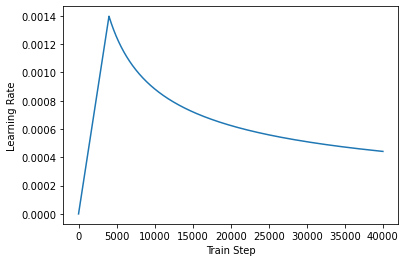

In [81]:
temp_learning_rate_schedule = CustomSchedule(embedding_dim)

plt.plot(temp_learning_rate_schedule(tf.range(40000, dtype=tf.float32)))
plt.ylabel('Learning Rate')
plt.xlabel('Train Step')
plt.show()

In [82]:
# define loss object
# from_logits = False, because we apply softmax to final Dense layer of Transformer
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=False, reduction='none')    


In [88]:
def loss_function(real, pred):
                                                            # real = (m, Ty)
                                                            # pred = (m, Ty, num_tokens_target)

  mask = tf.math.logical_not(tf.math.equal(real, 0))        # select only non-zero values
                                                            # mask = (m, Ty)

  loss_ = loss_object(real, pred)                           # loss = (m, Ty)

  mask = tf.cast(mask, dtype=loss_.dtype)                   
  loss_ *= mask                                             # only count loss from non-zero values

  return tf.reduce_sum(loss_)/tf.reduce_sum(mask)           # divide loss by number of non-zero values


def accuracy_function(real, pred):                          # pred = (m, Ty, num_tokens_target)
  accuracies = tf.equal(real, tf.cast(tf.argmax(pred, axis=2), tf.int32))      # accuracies = (m, Ty) -- binary values

  mask = tf.math.logical_not(tf.math.equal(real, 0))        # mask = (m, Ty) -- boolean values
  accuracies = tf.math.logical_and(mask, accuracies)        # suppress values where real value is 0

  accuracies = tf.cast(accuracies, dtype=tf.float32)
  mask = tf.cast(mask, dtype=tf.float32)
  return tf.reduce_sum(accuracies)/tf.reduce_sum(mask)      # divide sum of 1s in "accuracies" by sum of 1s in "mask"

In [89]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.Mean(name='train_accuracy')

In [90]:
# Transformer arguments: 
# num_layers, embedding_dim, num_heads, fully_connected_dim, input_vocab_size, 
# target_vocab_size, max_positional_encoding_input,
# max_positional_encoding_target, dropout_rate=0.1, layernorm_eps=1e-6

transformer = Transformer(
    num_layers=num_layers,
    embedding_dim=embedding_dim,
    num_heads=num_heads,
    fully_connected_dim=fully_connected_dim,
    input_vocab_size=input_vocab_size,
    target_vocab_size=target_vocab_size,
    max_positional_encoding_input = max_positional_encoding_input,
    max_positional_encoding_target = max_positional_encoding_target
    )

(1, 29, 128)
(1, 27, 128)


In [91]:
@tf.function
def train_step(inp, tar):
                            # inp = (m, Tx)
                            # tar = (m, Ty)


  tar_inp = tar[:, :-1]     # "start_" to last word
  tar_real = tar[:, 1:]     # first word to "_end"

  with tf.GradientTape() as tape:
    predictions, _ = transformer(inputs = (inp, tar_inp),
                                 training = True)
    loss = loss_function(tar_real, predictions)

  gradients = tape.gradient(loss, transformer.trainable_variables)
  optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))

  train_loss(loss)
  train_accuracy(accuracy_function(tar_real, predictions))

In [479]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 transformer=transformer)

In [480]:
for epoch in range(5):
  start = time.time()

  train_loss.reset_states()
  train_accuracy.reset_states()

  # inp -> portuguese, tar -> english
  for (batch, (inp, tar)) in enumerate(dataset):
    train_step(inp, tar)

    if batch % 50 == 0:
      print(f'Epoch {epoch + 1} Batch {batch} Loss {train_loss.result():.4f} Accuracy {train_accuracy.result():.4f}')


  checkpoint.save(file_prefix = checkpoint_prefix)
  
  print(f'Epoch {epoch + 1} Loss {train_loss.result():.4f} Accuracy {train_accuracy.result():.4f}')

  print(f'Time taken for 1 epoch: {time.time() - start:.2f} secs\n')

Epoch 1 Batch 0 Loss 1.4101 Accuracy 0.6976
Epoch 1 Batch 50 Loss 1.2124 Accuracy 0.7197
Epoch 1 Batch 100 Loss 1.1857 Accuracy 0.7293
Epoch 1 Batch 150 Loss 1.1737 Accuracy 0.7321
Epoch 1 Batch 200 Loss 1.1641 Accuracy 0.7335
Epoch 1 Batch 250 Loss 1.1523 Accuracy 0.7363
Epoch 1 Batch 300 Loss 1.1429 Accuracy 0.7380
Epoch 1 Loss 1.1443 Accuracy 0.7379
Time taken for 1 epoch: 124.61 secs

Epoch 2 Batch 0 Loss 1.0738 Accuracy 0.7581
Epoch 2 Batch 50 Loss 1.0321 Accuracy 0.7595
Epoch 2 Batch 100 Loss 1.0207 Accuracy 0.7613
Epoch 2 Batch 150 Loss 1.0099 Accuracy 0.7631
Epoch 2 Batch 200 Loss 1.0096 Accuracy 0.7631
Epoch 2 Batch 250 Loss 1.0010 Accuracy 0.7651
Epoch 2 Batch 300 Loss 0.9930 Accuracy 0.7674
Epoch 2 Loss 0.9961 Accuracy 0.7667
Time taken for 1 epoch: 131.57 secs

Epoch 3 Batch 0 Loss 1.0202 Accuracy 0.7471
Epoch 3 Batch 50 Loss 0.9218 Accuracy 0.7796
Epoch 3 Batch 100 Loss 0.9094 Accuracy 0.7818
Epoch 3 Batch 150 Loss 0.8889 Accuracy 0.7862
Epoch 3 Batch 200 Loss 0.8876 Accur

In [481]:
def evaluate(source_input, transformer, max_source_length, max_target_length):
    """
    Arguments: 
    source_input -- (1, Tx) -- input sequence integers

    Returns:
    pred_sentence -- predicted sentence in words
    input_sentence -- input sentence in words
    """

    # Translate sequence of integers into words
    input_sentence = ''
    for i in source_input[0]:
        if i == 0:
            break
        input_sentence = input_sentence + source_sentence_tokenizer.index_word[i] + ' '

    source_input = tf.convert_to_tensor(source_input)

    # transformer call function: 
    # Arguments: inputs, training
        # inputs: 
            # input_sentence -- (batch_size, input_seq_len)
            # output_sentence -- (batch_size, target_seq_len)
    # Returns: 
    # final_output -- (batch_size, tar_seq_len, target_vocab_size)
    # attention_weights


    # Define tokens for "start_" and "_end"
    start = target_sentence_tokenizer.word_index['start_']
    end = target_sentence_tokenizer.word_index['_end']
    
    # Initialise output_array with "start_" token
    #output_array = tf.TensorArray(dtype=tf.int64, size=0, dynamic_size=True)
    #output_array = output_array.write(0, start)
    output_array = tf.Variable([start], dtype = tf.int64 )
    output_array = tf.expand_dims(output_array, 0)

    pred_sentence = ''
    for t in range (max_target_length):
        #output = tf.transpose(output_array.stack())   # tf.expand_dims(tf.transpose(output_array.stack()), 0)
        output = output_array
        
        predictions, _ = transformer([source_input, output], training = False)       # (batch_size, tar_seq_len, target_vocab_size)
        
        predictions = predictions[:, -1:, :]                                      # select final time-step of predictions
        
        predicted_id = tf.argmax(predictions, axis=-1)
        
        predicted_id_int = int(predicted_id)
        
        pred_sentence += target_sentence_tokenizer.index_word[predicted_id_int] + ' '
        output_array = tf.concat([output_array, predicted_id], axis = 1)


        if predicted_id == end:
            break
    
        

    # get attention_weights for final time-step excluding the "_end" token
    _, attention_weights = transformer([source_input, output_array[:, :-1]], training = False)
    #output = tf.transpose(output_array.stack())          # output = (1, tokens)
    
    return pred_sentence, input_sentence, attention_weights
        


In [482]:
def predict_random_val_sentence(transformer):
    
    k = np.random.randint(len(source_train_tensor))
    random_input = source_train_tensor[k]
    random_output = target_train_tensor[k]
    random_input = np.expand_dims(random_input,0)           # random_input = (1, Tx)
        
    pred_sentence, input_sentence, attention_weights = evaluate(random_input, transformer, max_source_length, max_target_length)

    print(f'Input: {input_sentence}')
    print(f'Predicted translation: {pred_sentence}')
    
    true_translation = ''
    for i in random_output:
        if i == 0:
            break
        true_translation = true_translation + target_sentence_tokenizer.index_word[i] + ' '

    print(f'Actual translation: {true_translation}')
    return pred_sentence, input_sentence, attention_weights


In [483]:
def plot_attention_weights(pred_sentence, input_sentence, attention_weights):
    """
    attention_weights is a dictionary for each block of each decoder layer
    """
    
    pred_sentence, input_sentence = pred_sentence.split(' '), input_sentence.split(' ')
    pred_sentence, input_sentence = pred_sentence[:-1], input_sentence[:-1]             # remove empty string at final index
    len_input = len(input_sentence)

    # retrieve final key of dictionary – this corresponds to the final decoder layer, block 2 (decoder-encoder mha)
    final_block_decenc = list(attention_weights.keys())[-1]
    print(final_block_decenc)
    attention_block = attention_weights[final_block_decenc]     # attention_weights is a dictionary
                                                                # attention_block = (1, num_heads, len(pred_sentence), Tx)
    attention_block_squeezed = tf.squeeze(attention_block, 0)   # attention_block_squeezed = (num_heads, len(pred_sentence), Tx)
    num_heads = attention_block_squeezed.shape[0]

    fig, ax = plt.subplots(num_heads, 1, figsize = (14,14))
    
    for head in range (num_heads):
        temp_attn_block = attention_block_squeezed[head]
        temp_attn_block = np.around(temp_attn_block, 3)
        ax[head].set_title(f'Head {head}')
        sns.heatmap(temp_attn_block[:,:len_input], ax = ax[head], cmap = 'hot', annot = True, xticklabels = input_sentence, yticklabels = pred_sentence)
    
    plt.tight_layout()
    plt.show()

In [484]:
pred_sentence, input_sentence, attention_weights = predict_random_val_sentence(transformer)

Input: start_ her dream has come true at last _end 
Predicted translation: ihr traum wurde endlich wahr _end 
Actual translation: start_ ihr traum wurde endlich wahr _end 


decoder_layer4_block2_decenc_att


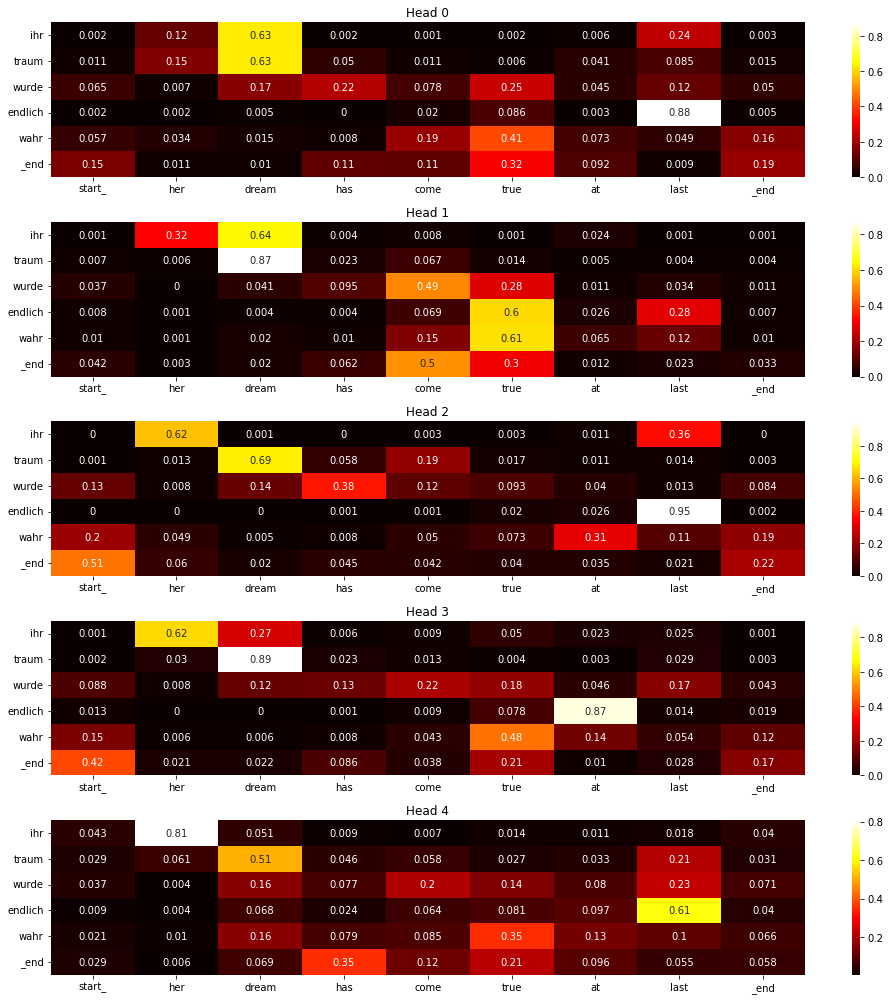

In [485]:
plot_attention_weights(pred_sentence, input_sentence, attention_weights)

In [464]:
transformer.summary()

Model: "transformer_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_6 (Encoder)         multiple                  2540032   
                                                                 
 decoder_6 (Decoder)         multiple                  4235136   
                                                                 
 dense_118 (Dense)           multiple                  1075731   
                                                                 
Total params: 7,850,899
Trainable params: 7,850,899
Non-trainable params: 0
_________________________________________________________________


In [474]:
file_path = 'saved_models/'
transformer.save_weights(file_path,save_format='tf')

# # Recreate the exact same model purely from the file
# new_model = keras.models.load_model('path_to_my_model')

In [475]:
new_transformer = Transformer(
        num_layers=num_layers,
    embedding_dim=embedding_dim,
    num_heads=num_heads,
    fully_connected_dim=fully_connected_dim,
    input_vocab_size=input_vocab_size,
    target_vocab_size=target_vocab_size,
    max_positional_encoding_input = max_positional_encoding_input,
    max_positional_encoding_target = max_positional_encoding_target
)


(1, 29, 128)
(1, 27, 128)


In [476]:
new_transformer.load_weights(file_path)

In [477]:
pred_sentence, input_sentence, attention_weights = predict_random_val_sentence(new_transformer)

Input: start_ you can always ask us for help _end 
Predicted translation: du kannst immer wenn wir immer helfen koennen _end 
Actual translation: start_ du kannst uns immer um hilfe beten _end 


decoder_layer4_block2_decenc_att


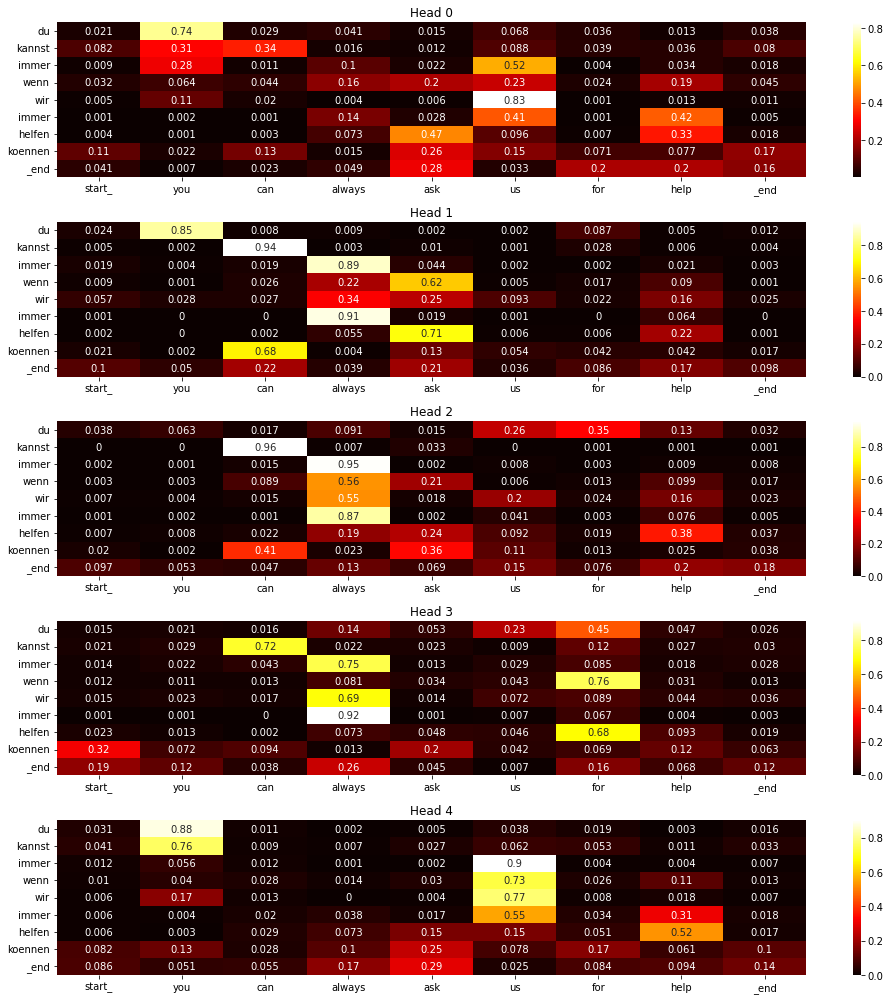

In [478]:
plot_attention_weights(pred_sentence, input_sentence, attention_weights)